# Acknowledgements
The data is provided by John Hopkins University github repository, https://github.com/CSSEGISandData/COVID-19.
The analysis in this notebook is based on the data up to October 30th, 2020.

# Libraries

In [338]:
import math
import numpy as np 
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px

plt.style.use('bmh')    # print(plt.style.available)


In [339]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# Datasets

#### I use three datasets which give the number of confirmed cases, the number of deaths and the number of people recovered. 

In [340]:
# confirmed
cdf = pd.read_csv('../input/covid19-october2020/time_series_covid19_confirmed_global.csv')
# deaths
ddf = pd.read_csv('../input/covid19-october2020/time_series_covid19_deaths_global.csv')
# recovered
rdf = pd.read_csv('../input/covid19-october2020/time_series_covid19_recovered_global.csv')

cdf.head(15)
#ddf.head()
#rdf.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,11/19/20,11/20/20,11/21/20,11/22/20,11/23/20,11/24/20,11/25/20,11/26/20,11/27/20,11/28/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,44228,44443,44503,44706,44988,45280,45490,45716,45839,45966
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,30623,31459,32196,32761,33556,34300,34944,35600,36245,36790
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,71652,72755,73774,74862,75867,77000,78025,79110,80168,81212
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,6066,6142,6207,6256,6304,6351,6428,6534,6610,6610
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,14134,14267,14413,14493,14634,14742,14821,14920,15008,15087
5,NaN,Antigua and Barbuda,17.06080,-61.796400,0,0,0,0,0,0,...,139,139,139,139,139,139,140,141,141,141
6,NaN,Argentina,-38.41610,-63.616700,0,0,0,0,0,0,...,1349434,1359042,1366182,1370366,1374631,1381795,1390388,1399431,1407277,1413375
7,NaN,Armenia,40.06910,45.038200,0,0,0,0,0,0,...,121979,123646,124839,126224,126709,127522,129085,130870,132346,133594
8,Australian Capital Territory,Australia,-35.47350,149.012400,0,0,0,0,0,0,...,115,115,115,115,115,115,115,116,117,117
9,New South Wales,Australia,-33.86880,151.209300,0,0,0,0,3,4,...,4517,4527,4538,4542,4548,4552,4552,4556,4564,4568


#### Cleaning.

In [341]:
# cleaning: ignore regions and coordinates

prev_datasets = [cdf, ddf, rdf]
new_datasets = []
for prev in prev_datasets:
    new = prev.drop(['Lat','Long'], axis=1).groupby('Country/Region').agg('sum').reset_index()
    new.rename(columns={'Country/Region':'Country'}, inplace=True)
    new_datasets.append(new)    
cdf_countries = new_datasets[0]
ddf_countries = new_datasets[1]
rdf_countries = new_datasets[2]

cdf_countries

,Country,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,11/19/20,11/20/20,11/21/20,11/22/20,11/23/20,11/24/20,11/25/20,11/26/20,11/27/20,11/28/20
0,Afghanistan,0,0,0,0,0,0,0,0,0,...,44228,44443,44503,44706,44988,45280,45490,45716,45839,45966
1,Albania,0,0,0,0,0,0,0,0,0,...,30623,31459,32196,32761,33556,34300,34944,35600,36245,36790
2,Algeria,0,0,0,0,0,0,0,0,0,...,71652,72755,73774,74862,75867,77000,78025,79110,80168,81212
3,Andorra,0,0,0,0,0,0,0,0,0,...,6066,6142,6207,6256,6304,6351,6428,6534,6610,6610
4,Angola,0,0,0,0,0,0,0,0,0,...,14134,14267,14413,14493,14634,14742,14821,14920,15008,15087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,West Bank and Gaza,0,0,0,0,0,0,0,0,0,...,67296,68768,70254,71644,73196,75007,76727,78493,80429,81890
187,Western Sahara,0,0,0,0,0,0,0,0,0,...,10,10,10,10,10,10,10,10,10,10
188,Yemen,0,0,0,0,0,0,0,0,0,...,2086,2090,2093,2099,2107,2114,2124,2137,2148,2160
189,Zambia,0,0,0,0,0,0,0,0,0,...,17350,17373,17394,17424,17454,17466,17535,17553,17569,17589


#### Below I create the fully grouped dataset, that is each row corresponds to certain date and country. The rows are arranged first by dates, then by countries.

In [342]:
# Fully grouped common dataset: first by dates, then by countries
# len = (number of days) * (number of countries) 

n = len(cdf_countries.drop('Country', axis=1).columns)  # number of days considered, 282 originally
c = len(cdf_countries)  # number of countries considered, 190 originally

dates = [i for i in cdf_countries.columns[1:]]
countries = [i for i in cdf_countries['Country']]
confirmed = cdf_countries.drop('Country', axis=1).T.values.flatten()  # flatten 2d array
deaths = ddf_countries.drop('Country', axis=1).T.values.flatten()
recovered = rdf_countries.drop('Country', axis=1).T.values.flatten()
active = confirmed - deaths - recovered

d={'Date': np.repeat(dates, c), 'Country': countries*n, 'Confirmed': confirmed, 'Deaths':deaths,
   'Recovered':recovered, 'Active':active}
grouped1_df = pd.DataFrame(d)
grouped1_df['Date'] = pd.to_datetime(grouped1_df['Date'], format='%m/%d/%y')
#grouped1_df.head(20)
grouped1_df.head(10)

,Date,Country,Confirmed,Deaths,Recovered,Active
0,2020-01-22,Afghanistan,0,0,0,0
1,2020-01-22,Albania,0,0,0,0
2,2020-01-22,Algeria,0,0,0,0
3,2020-01-22,Andorra,0,0,0,0
4,2020-01-22,Angola,0,0,0,0
5,2020-01-22,Antigua and Barbuda,0,0,0,0
6,2020-01-22,Argentina,0,0,0,0
7,2020-01-22,Armenia,0,0,0,0
8,2020-01-22,Australia,0,0,0,0
9,2020-01-22,Austria,0,0,0,0


#### The following dataset is obtained from the one above by considering every fifth date (used later so that the animation is of reasonable rate). 

In [343]:
# grouped1_df -> every 5th date
# c=number of countries, n is number of dates. Originally c=190, n=282

chunks = [range(i,i+c) for i in range(n*c) if i%c == 0]    
every5thchunk = chunks[::5]
merged = list(itertools.chain.from_iterable(every5thchunk))
grouped1_df_every5thdate = grouped1_df.iloc[merged]
grouped1_df_every5thdate

,Date,Country,Confirmed,Deaths,Recovered,Active
0,2020-01-22,Afghanistan,0,0,0,0
1,2020-01-22,Albania,0,0,0,0
2,2020-01-22,Algeria,0,0,0,0
3,2020-01-22,Andorra,0,0,0,0
4,2020-01-22,Angola,0,0,0,0
...,...,...,...,...,...,...
59396,2020-11-27,West Bank and Gaza,80429,689,61960,17780
59397,2020-11-27,Western Sahara,10,1,8,1
59398,2020-11-27,Yemen,2148,614,1491,43
59399,2020-11-27,Zambia,17569,357,16845,367


#### Below I create the second fully grouped dataset. Now the rows are arranged first by countries, then by dates.

In [344]:
# Fully grouped common dataset: first by countries, then by dates
# len = (number of days) * (number of countries) 

n = len(cdf_countries.drop('Country', axis=1).columns)  # number of days considered, 282 originally
c = len(cdf_countries)  # number of countries considered, 190 originally

dates = [i for i in cdf_countries.columns[1:]]
countries = [i for i in cdf_countries['Country']]
confirmed = cdf_countries.drop('Country', axis=1).values.flatten()  # flatten 2d array
deaths = ddf_countries.drop('Country', axis=1).values.flatten()
recovered = rdf_countries.drop('Country', axis=1).values.flatten()
active = confirmed - deaths - recovered

d={'Country': np.repeat(countries, n), 'Date': dates*c, 'Confirmed': confirmed, 'Deaths':deaths,
   'Recovered':recovered, 'Active':active}
grouped2_df = pd.DataFrame(d)
grouped2_df['Date'] = pd.to_datetime(grouped2_df['Date'], format='%m/%d/%y')
grouped2_df

,Country,Date,Confirmed,Deaths,Recovered,Active
0,Afghanistan,2020-01-22,0,0,0,0
1,Afghanistan,2020-01-23,0,0,0,0
2,Afghanistan,2020-01-24,0,0,0,0
3,Afghanistan,2020-01-25,0,0,0,0
4,Afghanistan,2020-01-26,0,0,0,0
...,...,...,...,...,...,...
59587,Zimbabwe,2020-11-24,9398,274,8297,827
59588,Zimbabwe,2020-11-25,9508,274,8336,898
59589,Zimbabwe,2020-11-26,9623,274,8397,952
59590,Zimbabwe,2020-11-27,9714,275,8470,969


#### Today, by countries

In [345]:
# Countries, today. Originally: 10/29/20

today_df = grouped1_df.iloc[-190:].set_index('Date')
today_df['Deaths/100 cases']=(today_df['Deaths']/today_df['Confirmed'])*100
today_df = today_df.round(2)
today_df.tail(20)

,Country,Confirmed,Deaths,Recovered,Active,Deaths/100 cases
Date,,,,,,
2020-11-28,Timor-Leste,30,0,30,0,0.00
2020-11-28,Togo,2946,64,2435,447,2.17
2020-11-28,Trinidad and Tobago,6630,118,5732,780,1.78
2020-11-28,Tunisia,94980,3153,69226,22601,3.32
2020-11-28,Turkey,578347,13373,396227,168747,2.31
2020-11-28,US,13244417,266047,5023063,7955307,2.01
2020-11-28,Uganda,19944,201,8944,10799,1.01
2020-11-28,Ukraine,728834,12485,350189,366160,1.71
2020-11-28,United Arab Emirates,166502,569,153449,12484,0.34


#### Today, world

In [346]:
# World, today. Originally: 10/29/20

today = today_df.index[0]   # originally today='10/29/20'
temp_df = today_df.copy()    # I add last row: world 
temp_df.loc[str(c)] = temp_df.sum()    # c is the number of countries considered
temp_df.at[str(c), 'Country'] = 'World'
temp_df.at[str(c), '% of deaths'] = (temp_df.at[str(c), 'Deaths']/temp_df.at[str(c), 'Confirmed'])*100

temp_df.rename(index={str(c): today}, inplace=True)

todayW_df = temp_df.drop('Confirmed', axis=1).tail(1)
todayW_df

,Country,Deaths,Recovered,Active,Deaths/100 cases,% of deaths
Date,,,,,,
2020-11-28,World,1450658,39765008,20982549,415.54,2.332315


In [347]:
# figure for the dataset todayW_df

#fig = px.treemap(todayW_df, path=['variable'], values='value', height=250)
#fig.data[0].textinfo = 'label+text+value'
#fig.show()

# Maps

In [348]:
def draw_map(df, column, cs):        # cs for color scale 
    fig = px.choropleth(df, locations='Country', locationmode='country names', color=column, hover_name='Country', 
                  title='{} as of {}'.format(column, today.date()), hover_data=[column],
                  color_continuous_scale=cs)   # px.colors.sequential.
    fig.show()      

In [349]:
draw_map(today_df, 'Confirmed', 'Blues')

In [350]:
draw_map(today_df, 'Active', 'deep')

In [351]:
draw_map(today_df, 'Deaths', 'Blues')

In [352]:
draw_map(today_df, 'Deaths/100 cases', 'deep')

In [353]:
def animation_map(df, column):
    fig = px.choropleth(df, locations='Country', locationmode='country names', hover_name='Country',
                        color=df[column],   # np.log
                        title='Cases over time', animation_frame=df['Date'].dt.strftime('%Y-%m-%d'),
                        color_continuous_scale=px.colors.sequential.Blues)
    fig.update(layout_coloraxis_showscale=False)
    fig.update_layout(transition = {'duration': 10})
    fig.show()

In [354]:
animation_map(grouped1_df_every5thdate, 'Confirmed')

# Top 15 countries


In [355]:
def plot_hbar(df, column, n=15, hover_data=[]):
    fig = px.bar(df.sort_values(column).tail(n), x=column, y="Country", color='Country',  
                 text=column, orientation='h', width=900, hover_data=hover_data,
                 color_discrete_sequence = px.colors.qualitative.Prism) 
    fig.update_traces(texttemplate='%{text:.3s}', textposition='outside')
    fig.update_layout(title=column, xaxis_title='', yaxis_title='', yaxis_categoryorder='total ascending',
                      uniformtext_minsize=8, uniformtext_mode='hide') # margin=dict(l=50, r=50, b=100, t=100, pad=4)
    fig.show()

In [356]:
plot_hbar(today_df, 'Confirmed')

In [357]:
plot_hbar(today_df, 'Active')

In [358]:
plot_hbar(today_df, 'Deaths')

In [359]:
plot_hbar(today_df, 'Deaths/100 cases')

In [360]:
def plot_line(df, column, n=6):
    top_n = grouped1_df.sort_values(column)[grouped1_df['Date']==today].tail(n)['Country'].to_numpy()
    #top10_df = grouped1_df[grouped1_df['Country'].isin(top_n)]     or
    top10_df = grouped1_df.query('Country in @top_n')
    
    fig = px.line(top10_df, x='Date', y=column, color='Country', height=600, 
                  title=column,    # '{} as of {}'.format(column, today.date()) 
                  color_discrete_sequence = px.colors.qualitative.Dark24)
    fig.update_layout(showlegend=True, xaxis_title='', yaxis_title='')
    fig.show()

In [361]:
plot_line(grouped2_df, 'Confirmed')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [362]:
plot_line(grouped2_df, 'Active')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [363]:
plot_line(grouped2_df, 'Deaths')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [364]:
def plot_treemap(df, column):
    fig = px.treemap(df, path=['Country'], values=column, height=600,
                 title=column, color_discrete_sequence = px.colors.qualitative.Prism)
    fig.data[0].textinfo = 'label+text+value'
    fig.show()

In [365]:
plot_treemap(today_df, 'Confirmed')

In [366]:
plot_treemap(today_df, 'Active')

In [367]:
plot_treemap(today_df, 'Deaths')

In [368]:
plot_treemap(today_df, 'Deaths/100 cases')

In [369]:
def plot_bubble(df, column):
    temp = df[df[column]>0].sort_values('Country', ascending=False)
    fig = px.scatter(temp, x='Date', y='Country', size=column, color=column, height=3000, title=column,
                    color_continuous_scale=px.colors.sequential.ice)  # Aggrnyl 
    fig.update_layout(yaxis=dict(dtick=1), xaxis_title='', yaxis_title='') 
    fig.update(layout_coloraxis_showscale=False)
    fig.show()

In [370]:
plot_bubble(grouped1_df, 'Confirmed')

# US - Machine Learning

### Preparation

In [371]:
US_df = grouped1_df[grouped1_df['Country']=='US'].groupby(['Date']).agg({'Confirmed':'sum', 'Deaths':'sum', 'Recovered':'sum', 'Active':'sum'})
US_df.tail()

,Confirmed,Deaths,Recovered,Active
Date,,,,
2020-11-24,12591163,259925,4696664,7634574
2020-11-25,12772653,262222,4835956,7674475
2020-11-26,12883264,263454,4871203,7748607
2020-11-27,13088821,264858,4947446,7876517
2020-11-28,13244417,266047,5023063,7955307


In [372]:
US_df['Days since 1/22'] = US_df.index - US_df.index[0]
US_df['Days since 1/22'] = US_df['Days since 1/22'].dt.days
US_df.head()

,Confirmed,Deaths,Recovered,Active,Days since 1/22
Date,,,,,
2020-01-22,1,0,0,1,0
2020-01-23,1,0,0,1,1
2020-01-24,2,0,0,2,2
2020-01-25,2,0,0,2,3
2020-01-26,5,0,0,5,4


In [381]:
cutpoint = int(US_df.shape[0]*0.9)
train = US_df.iloc[:cutpoint]
valid = US_df.iloc[cutpoint:]

model_scores = []

### Linear regression

In [374]:
lin_reg = LinearRegression(normalize=True)
lin_reg.fit(np.array(train['Days since 1/22']).reshape(-1,1), np.array(train['Confirmed']).reshape(-1,1))
prediction_lr = lin_reg.predict(np.array(valid['Days since 1/22']).reshape(-1,1))
model_scores.append(np.sqrt(mean_squared_error(valid['Confirmed'], prediction_lr)))

print('Square root of MSE for Liner Regression is', model_scores[0])

Square root of MSE for Liner Regression is 2903164.2403332936


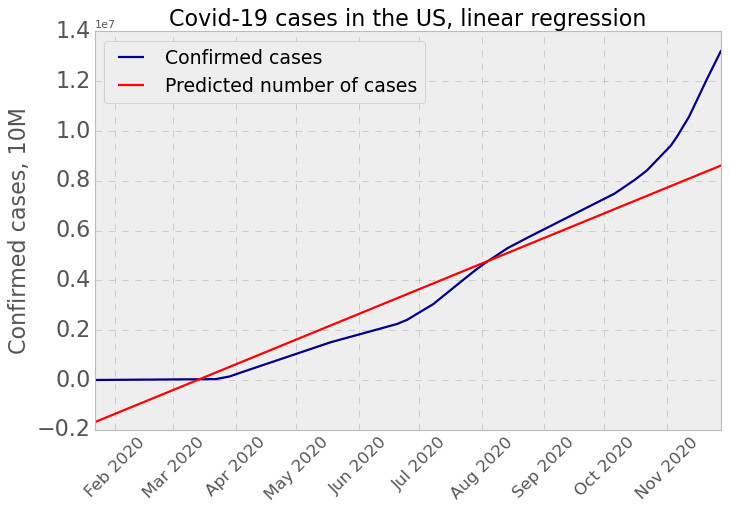

In [375]:
def plot_LR():
    df = US_df
    pred = lin_reg.predict(np.array(df['Days since 1/22']).reshape(-1,1))
    plt.figure(figsize=(9,6))
    plt.plot(df['Confirmed'], label='Confirmed cases', color='darkblue')
    plt.plot(df.index, pred, label='Predicted number of cases', color='red')
    plt.title('Covid-19 cases in the US, linear regression', fontsize=20)
    plt.xticks(rotation=45, size=15 )
    plt.ylabel('Confirmed cases, 10M', fontsize=20)
    plt.yticks(size=20)
    plt.legend(loc=2, prop={'size': 17})

plot_LR()   

#### Linear regression definitely does not help

### Polynomial Regression

In [376]:
poly = PolynomialFeatures(degree=6)

train_poly = poly.fit_transform(np.array(train['Days since 1/22']).reshape(-1,1))
valid_poly = poly.fit_transform(np.array(valid['Days since 1/22']).reshape(-1,1))

In [377]:
lin_reg = LinearRegression(normalize=True)
lin_reg.fit(train_poly, train['Confirmed'])
prediction_pr = lin_reg.predict(valid_poly)
model_scores.append(np.sqrt(mean_squared_error(valid['Confirmed'], prediction_pr)))

print('Square root of MSE for Polynoial Regression is', model_scores[1])

Square root of MSE for Polynoial Regression is 609034.7918462247


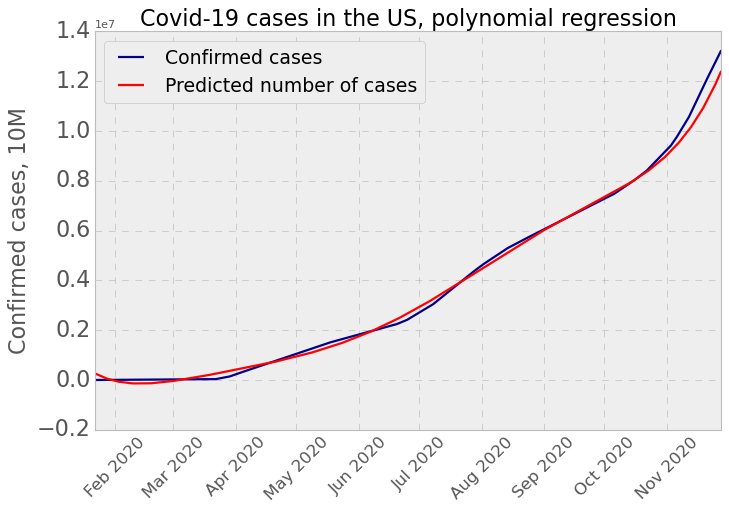

In [378]:
def plot_PR():
    df = US_df
    data = poly.fit_transform(np.array(df['Days since 1/22']).reshape(-1,1))
    pred = lin_reg.predict(data)
    plt.figure(figsize=(9,6))
    plt.plot(df['Confirmed'], label='Confirmed cases', color='darkblue')
    plt.plot(df.index, pred, label='Predicted number of cases', color='red') #, linestyle='--')
    plt.title('Covid-19 cases in the US, polynomial regression', fontsize=20)
    plt.xticks(rotation=45, size=15)
    plt.yticks(size=20)
    plt.ylabel('Confirmed cases, 10M', fontsize=20)
    plt.legend(loc=2, prop={'size': 17})
    
plot_PR()  

### Support Vector Machine

In [379]:
svm = SVR(C=1, degree=5, kernel='poly', epsilon=0.05)
svm.fit(np.array(train['Days since 1/22']).reshape(-1,1), np.array(train['Confirmed']).reshape(-1,1))
pred_svm = svm.predict(np.array(valid['Days since 1/22']).reshape(-1,1))
model_scores.append(np.sqrt(mean_squared_error(valid['Confirmed'], pred_svm)))

print('Square root of MSE for SVM is', model_scores[2])

Square root of MSE for SVM is 980222.651994272


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



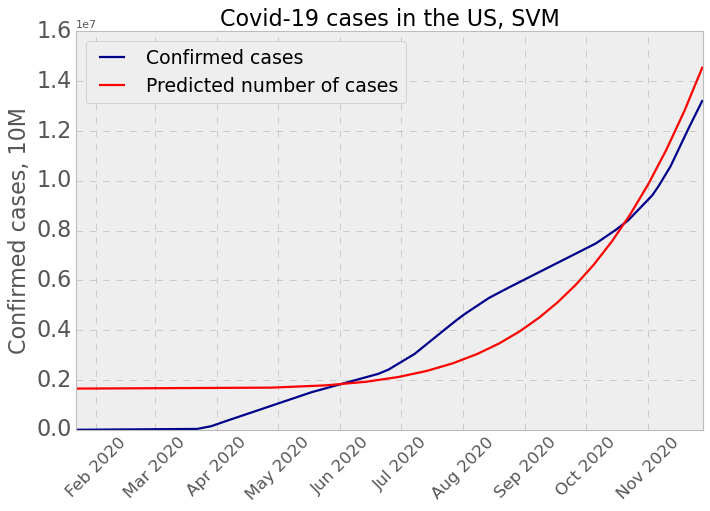

In [380]:
def plot_SVM():
    df = US_df
    pred = svm.predict(np.array(df['Days since 1/22']).reshape(-1,1))
    plt.figure(figsize=(9,6))
    plt.plot(df['Confirmed'], label='Confirmed cases', color='darkblue')
    plt.plot(df.index, pred, label='Predicted number of cases', color='red') #, linestyle='--')
    plt.title('Covid-19 cases in the US, SVM', fontsize=20)
    plt.xticks(rotation=45, size=15)
    plt.yticks(size=20)
    plt.ylabel('Confirmed cases, 10M', fontsize=20)
    plt.legend(loc=2, prop={'size': 17})
    
plot_SVM()  